# Automatic sleep staging

This notebook demonstrates how to perform automatic sleep staging of polysomnography data in YASA. For more details, make sure to read the [eLife publication](https://elifesciences.org/articles/70092).

Please install the latest version of YASA first with: `pip install --upgrade yasa`.

In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data loading

The automatic sleep staging function requires that the data are loaded using the [MNE Python package](https://mne.tools/stable/index.html). For instance, if your polysomnography data are stored in the standard European Data Fomat (.edf), you can use [this function](https://mne.tools/stable/generated/mne.io.read_raw_edf.html?highlight=read_raw_edf#mne.io.read_raw_edf) to load the data into Python.

In [2]:
# Let's load a nap recording, directly as an MNE Raw object
raw = mne.io.read_raw_fif('sub-02_mne_raw.fif', preload=True, verbose=False)
print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])
raw

The channels are: ['F3', 'F4', 'C3', 'C4', 'O1', 'O2', 'EOG1', 'EOG2', 'EMG1']
The sampling frequency is: 100.0


<Raw | sub-02_mne_raw.fif, 9 x 294000 (2940.0 s), ~20.2 MB, data loaded>

In [3]:
# Let's now load the human-scored hypnogram, where each value represents a 30-sec epoch.
hyp = np.loadtxt('sub-02_hypno_30s.txt', dtype=str)
hyp

array(['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
       'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'N1', 'W', 'W', 'W',
       'W', 'N1', 'N1', 'N1', 'W', 'W', 'N1', 'N1', 'N1', 'N1', 'N2',
       'N2', 'N2', 'W', 'N1', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2',
       'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3',
       'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'N3', 'W',
       'W', 'W', 'W', 'W', 'W', 'W'], dtype='<U2')

In [4]:
# Convert it to a Hypnogram instance, which is the preferred way to manipulate hypnograms since v0.7
hyp = yasa.Hypnogram(hyp, freq="30s")
# The hypnogram values can be obtained with
hyp.hypno

Epoch
0     WAKE
1     WAKE
2     WAKE
3     WAKE
4     WAKE
      ... 
93    WAKE
94    WAKE
95    WAKE
96    WAKE
97    WAKE
Name: Stage, Length: 98, dtype: object

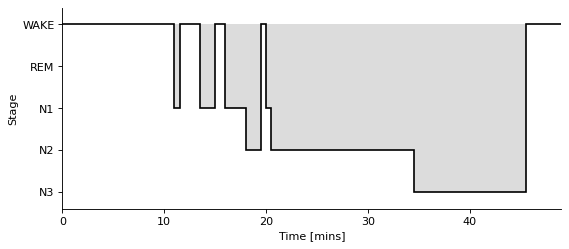

In [5]:
# Let's plot it
fig, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True, dpi=80)
ax = hyp.plot_hypnogram(fill_color="gainsboro", ax=ax)

## Sleep staging

Automatic sleep stages classification can be done since YASA 0.4.0 using the [SleepStaging](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging) class. Make sure to read the [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging), which explains how the algorithm works.

In [6]:
# We first need to specify the channel names and, optionally, the age and sex of the participant
# - "raw" is the name of the variable containing the polysomnography data loaded with MNE.
# - "eeg_name" is the name of the EEG channel, preferentially a central derivation (e.g. C4-M1). This is always required to run the sleep staging algorithm.
# - "eog_name" is the name of the EOG channel (e.g. LOC-M1). This is optional.
# - "eog_name" is the name of the EOG channel (e.g. EMG1-EMG3). This is optional.
# - "metadata" is a dictionary containing the age and sex of the participant. This is optional.
sls = yasa.SleepStaging(raw, eeg_name="C4", eog_name="EOG1", emg_name="EMG1", metadata=dict(age=21, male=False))

In [7]:
# Getting the predicted sleep stages is now as easy as:
y_pred = sls.predict()
y_pred.hypno

/Users/raphael/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch
0     WAKE
1     WAKE
2     WAKE
3     WAKE
4     WAKE
      ... 
93    WAKE
94    WAKE
95    WAKE
96    WAKE
97    WAKE
Name: Stage, Length: 98, dtype: object

In [8]:
# What is the accuracy of the prediction, compared to the human scoring
accuracy = 100 * (hyp.hypno == y_pred.hypno).mean()
print(f"The overall agreement is {accuracy:.2f}%")

The overall agreement is 83.67%


**Plot and sleep statistics**

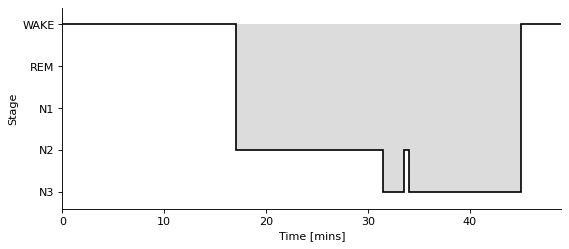

In [9]:
# Plot the predicted hypnogram
fig, ax = plt.subplots(1, 1, figsize=(7, 3), constrained_layout=True, dpi=80)
ax = y_pred.plot_hypnogram(fill_color="gainsboro", ax=ax)

In [10]:
# Calculate the summary sleep statistics of the predicted hypnogram
y_pred.sleep_statistics()

{'TIB': 49.0,
 'SPT': 28.0,
 'WASO': 0.0,
 'TST': 28.0,
 'SE': 57.1429,
 'SME': 100.0,
 'SFI': 1.0714,
 'SOL': 17.0,
 'SOL_5min': 17.0,
 'Lat_REM': nan,
 'WAKE': 21.0,
 'N1': 0.0,
 'N2': 15.0,
 'N3': 13.0,
 'REM': 0.0,
 '%N1': 0.0,
 '%N2': 53.5714,
 '%N3': 46.4286,
 '%REM': 0.0}

**Stage probabilities and confidence of the algorithm at each epoch**

In [11]:
# What are the predicted probabilities of each sleep stage at each epoch?
sls.predict_proba()

,N1,N2,N3,R,W
epoch,,,,,
0,0.002202,0.005040,0.000703,1.875966e-18,0.992055
1,0.003362,0.003284,0.001926,8.279263e-05,0.991345
2,0.004078,0.003225,0.000095,7.688612e-04,0.991833
3,0.001918,0.001771,0.000052,7.023297e-04,0.995557
4,0.002624,0.007565,0.000221,5.963933e-04,0.988994
...,...,...,...,...,...
93,0.004001,0.009041,0.004678,9.823759e-05,0.982182
94,0.001910,0.028894,0.136638,2.746406e-04,0.832283
95,0.001399,0.001958,0.000488,4.246366e-05,0.996112


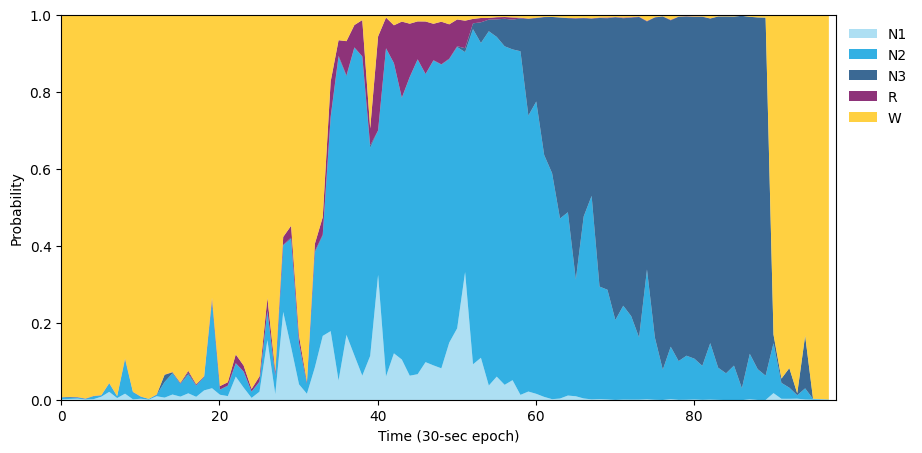

In [12]:
# Plot the predicted probabilities
sls.plot_predict_proba();

In [13]:
# From the probabilities, we can extract a confidence level (ranging from 0 to 1) for each epoch.
confidence = sls.predict_proba().max(1)
confidence

epoch
0     0.992055
1     0.991345
2     0.991833
3     0.995557
4     0.988994
        ...   
93    0.982182
94    0.832283
95    0.996112
96    0.997007
97    0.998046
Length: 98, dtype: float64

**Exporting to a CSV file**

In [14]:
# The predicted sleep stages can be exported to a CSV file with:
hyp.hypno.to_csv("my_hypno.csv")

In [15]:
# We can also add the confidence level:
df_pred = hyp.hypno.to_frame()
df_pred["Confidence"] = confidence
df_pred.head(6)

,Stage,Confidence
Epoch,,
0,WAKE,0.992055
1,WAKE,0.991345
2,WAKE,0.991833
3,WAKE,0.995557
4,WAKE,0.988994
5,WAKE,0.986805


In [16]:
# Now export to a CSV file
df_pred.to_csv("my_hypno.csv")

**Applying the detection using only a single EEG derivation**

In [17]:
# Using just an EEG channel (= no EOG or EMG)
y_pred = yasa.SleepStaging(raw, eeg_name="C4").predict()
y_pred.hypno

/Users/raphael/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch
0     WAKE
1     WAKE
2     WAKE
3     WAKE
4     WAKE
      ... 
93    WAKE
94    WAKE
95    WAKE
96    WAKE
97    WAKE
Name: Stage, Length: 98, dtype: object